In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_venn import venn3
import seaborn as sns

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import import_homer_diffgene, read_homer_gene_exp, read_annotated_peaks
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

In [3]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [4]:
workingDirectory = '/home/h1bennet/strains_rna/results/K03_CB6F1_Kupffer_RNA/'
dataDirectory = '/home/ttroutman/strainsKupffer/rnaKupfferF1/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

if not os.path.isdir('./promoter_motifs/'):
    os.mkdir('./promoter_motifs/')
    
if not os.path.isdir('./motif_scanning/'):
    os.mkdir('./motif_scanning/')
    
if not os.path.isdir('./figures/'):
    os.mkdir('./figures/')

To do this analysis we will pull from the differential analysis performed by Ty at the following location:  

     /home/ttroutman/strainsKupffer/rnaKupfferF1/
     
The following two files are relevant  

     /home/ttroutman/strainsKupffer/rnaKupfferF1/c57bl6j_perfect.vs.balbcj_perfect.scatter.txt
     /home/ttroutman/strainsKupffer/rnaKupfferF1/c57bl6j_control.vs.balbcj_control.scatter.txt

In [4]:
diffDir = '/home/ttroutman/strainsKupffer/rnaKupfferF1/rnaDiff/'
rnaQuan = '/home/ttroutman/strainsKupffer/rnaKupfferF1/rnaQuan/rawT.txt'


# Motif analysis

In another workbook we determined lists of cis, trans, and mixed genes, now we will look at motif enrichment at their promoters.

In [5]:
# %%bash

# for i in ./gene_lists/*.txt;
# do out=${i/gene_lists/promoter_motifs};
# out=${out/.txt/_motifs};
# findMotifs.pl $i mouse $out; done

Look for NFKB p65 motif

     findMotifs.pl ./gene_lists/cb6f1_kupffer_trans_c57_filt_pval.txt mouse ./motif_scanning/ \
     -find /bioinformatics/homer/motifs/nfkb.motif > ./motif_scanning/cb6f1_kupffer_trans_c57_filt_pval_nfkb.txt
     
     findMotifs.pl ./gene_lists/cb6f1_kupffer_trans_c57_filt_pval.txt mouse ./motif_scanning/ \
     -find /bioinformatics/homer/motifs/p50.motif > ./motif_scanning/cb6f1_kupffer_trans_c57_filt_pval_p50.txt
     
     findMotifs.pl ./gene_lists/cb6f1_kupffer_trans_c57_filt_pval.txt mouse ./motif_scanning/ \
     -find /bioinformatics/homer/motifs/p65.motif > ./motif_scanning/cb6f1_kupffer_trans_c57_filt_pval_p65.txt

# Metascape 

In [6]:
meta = pd.read_excel('./gene_lists/cb6f1_kupffer_trans_balb/metascape_result.xlsx',
                     sheet_name=1)

In [7]:
c57_terms = ['GO:0048002','GO:0031663','GO:0050778','ko04620']
c57_term_strings = ['Antigen Presentation',
                    'LPS Mediated Signaling',
                    'Pos. Reg. of Immune Resp.',
                    'TLR Signaling Pathway']
balb_terms = ['GO:0001906', 'GO:0070098', 'GO:0009154', 'ko04380']

In [8]:
meta_filt = meta.loc[meta['Term'].str.contains('|'.join(balb_terms))]
meta_filt = meta_filt.sort_values('LogP', ascending=True)
meta_filt = meta_filt.reindex(meta_filt.Term.drop_duplicates().index)

## Manually curate list of terms for each strain

In [9]:
c57_terms = ['GO:0048002','GO:0031663','GO:0050778','ko04620']
c57_term_strings = ['Antigen\nPresentation',
                    'LPS Mediated\nSignaling',
                    'Pos. Reg. of\nImmune Resp.',
                    'TLR Signaling\nPathway']
balb_terms = ['GO:0001906', 'GO:0070098', 'GO:0009154', 'ko04380']
balb_term_strings = ['Cell\nKilling',
                    'Chemokine\nSignaling',
                    'Osteoclast\ndiff.',
                    'Purine\nCatabolism']

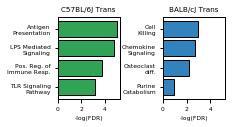

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3,1.5),
                               sharex=True)
plt.subplots_adjust(wspace=0.7)

meta = pd.read_excel('./gene_lists/cb6f1_kupffer_trans_c57/metascape_result.xlsx',
                     sheet_name=1)
meta_filt = meta.loc[meta['Term'].str.contains('|'.join(c57_terms))]
meta_filt = meta_filt.sort_values('LogP', ascending=True)
meta_filt = meta_filt.reindex(meta_filt.Term.drop_duplicates().index)

y_ind = np.arange(len(c57_terms))
enrichment = -meta_filt['Log(q-value)']
ax1.barh(y_ind,
         enrichment,
         align='center',
         linewidth=1,
         edgecolor='k',
         color='#31a354')
ax1.set_yticks(y_ind)
ax1.set_yticklabels(c57_term_strings)
ax1.invert_yaxis()
ax1.set_title('C57BL/6J Trans')
ax1.set_xlabel('-log(FDR)')


meta = pd.read_excel('./gene_lists/cb6f1_kupffer_trans_balb/metascape_result.xlsx',
                     sheet_name=1)
meta_filt = meta.loc[meta['Term'].str.contains('|'.join(balb_terms))]
meta_filt = meta_filt.sort_values('LogP', ascending=True)
meta_filt = meta_filt.reindex(meta_filt.Term.drop_duplicates().index)

y_ind = np.arange(len(balb_terms))
enrichment = -meta_filt['Log(q-value)']
ax2.barh(y_ind,
         enrichment,
         align='center',
         linewidth=1,
         edgecolor='k',
         color='#3182bd')
ax2.set_yticks(y_ind)
ax2.set_yticklabels(balb_term_strings)
ax2.invert_yaxis()
ax2.set_title('BALB/cJ Trans')
ax2.set_xlabel('-log(FDR)')

plt.savefig('../A10_Manuscript_Figures_AllLiverCells/rna_trans_enriched_GO_wide.pdf',
            bbox_inches='tight')

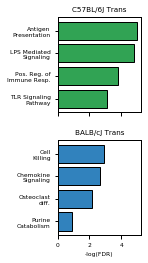

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(1.5,4),
                               sharex=True)
plt.subplots_adjust(hspace=0.3)

meta = pd.read_excel('./gene_lists/cb6f1_kupffer_trans_c57/metascape_result.xlsx',
                     sheet_name=1)
meta_filt = meta.loc[meta['Term'].str.contains('|'.join(c57_terms))]
meta_filt = meta_filt.sort_values('LogP', ascending=True)
meta_filt = meta_filt.reindex(meta_filt.Term.drop_duplicates().index)

y_ind = np.arange(len(c57_terms))
enrichment = -meta_filt['Log(q-value)']
ax1.barh(y_ind,
         enrichment,
         align='center',
         linewidth=1,
         edgecolor='k',
         color='#31a354')
ax1.set_yticks(y_ind)
ax1.set_yticklabels(c57_term_strings)
ax1.invert_yaxis()
ax1.set_title('C57BL/6J Trans')


meta = pd.read_excel('./gene_lists/cb6f1_kupffer_trans_balb/metascape_result.xlsx',
                     sheet_name=1)
meta_filt = meta.loc[meta['Term'].str.contains('|'.join(balb_terms))]
meta_filt = meta_filt.sort_values('LogP', ascending=True)
meta_filt = meta_filt.reindex(meta_filt.Term.drop_duplicates().index)

y_ind = np.arange(len(balb_terms))
enrichment = -meta_filt['Log(q-value)']
ax2.barh(y_ind,
         enrichment,
         align='center',
         linewidth=1,
         edgecolor='k',
         color='#3182bd')
ax2.set_yticks(y_ind)
ax2.set_yticklabels(balb_term_strings)
ax2.invert_yaxis()
ax2.set_title('BALB/cJ Trans')
ax2.set_xlabel('-log(FDR)')

plt.savefig('../A10_Manuscript_Figures_AllLiverCells/rna_trans_enriched_GO_long.pdf',
            bbox_inches='tight')